In [ ]:
# https://www.kaggle.com/c/platesv2/submit

In [1]:
import torch
import numpy as np
import pandas as pd
import random
import os
import shutil
import copy
import time
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm.notebook import tqdm
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn.functional import softmax

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
print(os.listdir('input'))

['test', 'train']


In [4]:
data_root = 'input'

In [5]:
dev_root = 'dev'

In [6]:
trn_dir = os.path.join(dev_root, 'train')
val_dir = os.path.join(dev_root, 'val')
class_names = ['cleaned', 'dirty']

In [7]:
for dir_name in [trn_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dev_root, dir_name, class_name), exist_ok=True)

In [8]:
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(trn_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

In [7]:
len(os.listdir('dev/train/cleaned/')), len(os.listdir('dev/train/dirty/'))

(16, 16)

In [8]:
# трансформации изображений
# TODO: albumentations

In [71]:
trn_transforms = transforms.Compose([transforms.CenterCrop(224),
                                     transforms.RandomPerspective(distortion_scale=0.1, p=0.8, interpolation=3, fill=255),
                                     # transforms.RandomResizedCrop(224),
                                     # transforms.Resize((224, 224)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomVerticalFlip(),
                                     # transforms.Grayscale(3),
                                     transforms.ColorJitter(hue=(-0.5,0.5)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])
val_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])

In [72]:
trn_dataset = ImageFolder(trn_dir, trn_transforms)
val_dataset = ImageFolder(val_dir, val_transforms)

In [92]:
batch_size = 24
num_workers = 0

In [93]:
trn_dataloader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [94]:
len(trn_dataloader), len(trn_dataset)

(2, 32)

In [95]:
def image_show(input_tensor, title=''):
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    image = input_tensor.permute(1, 2, 0).numpy()
    image = image * std + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

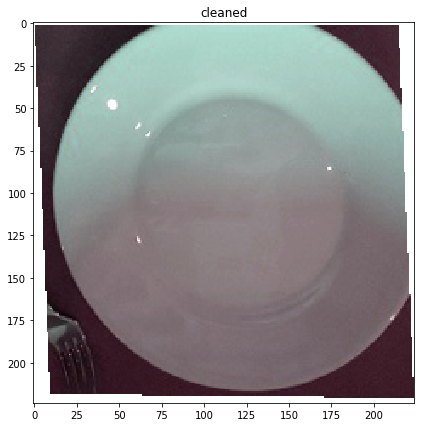

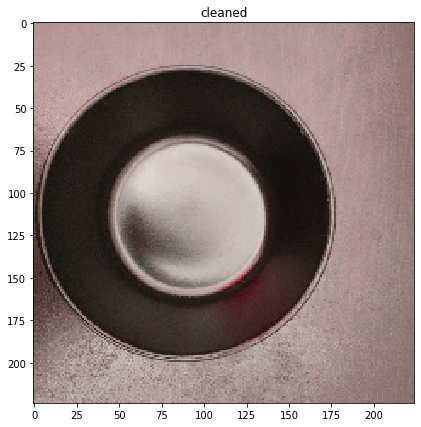

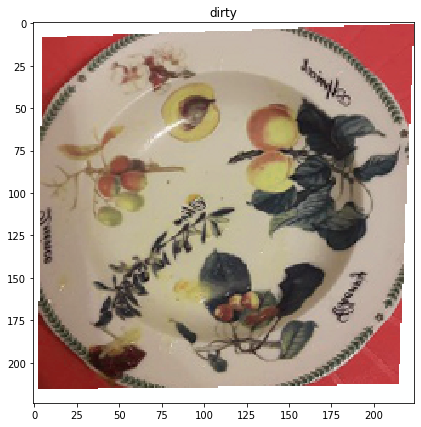

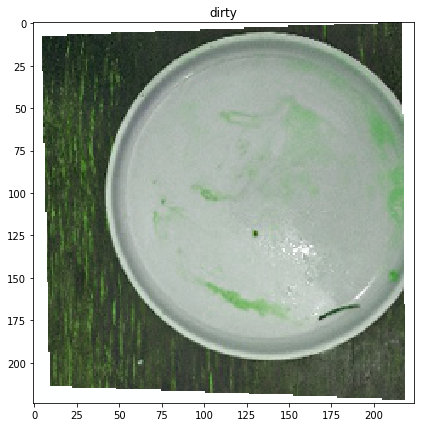

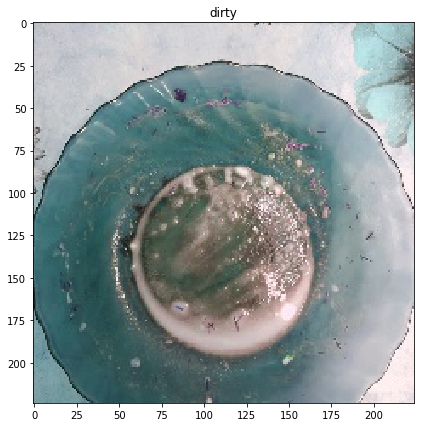

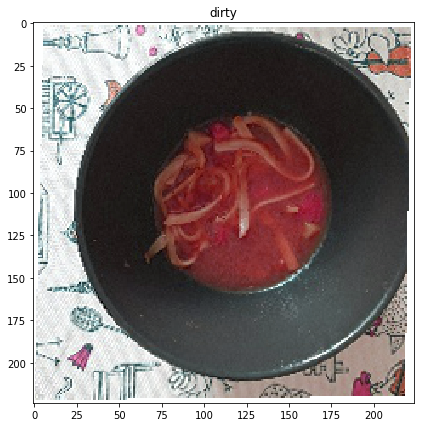

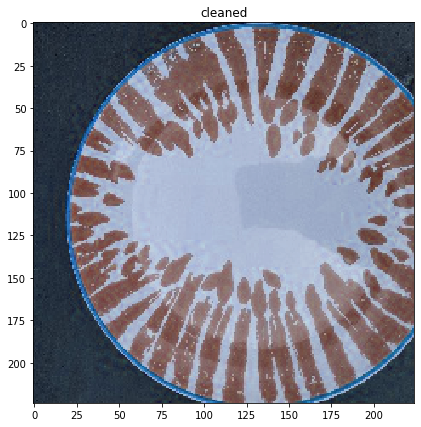

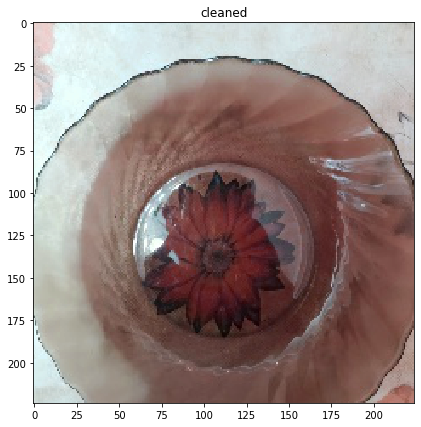

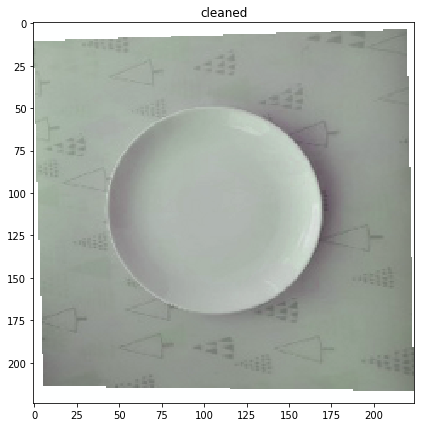

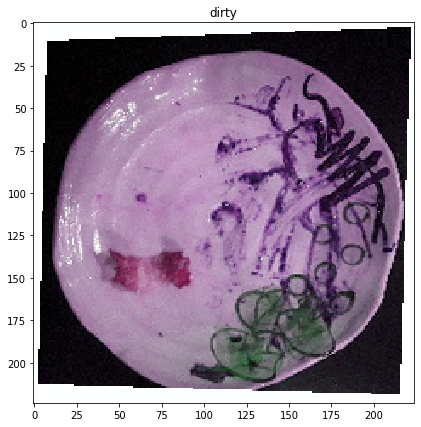

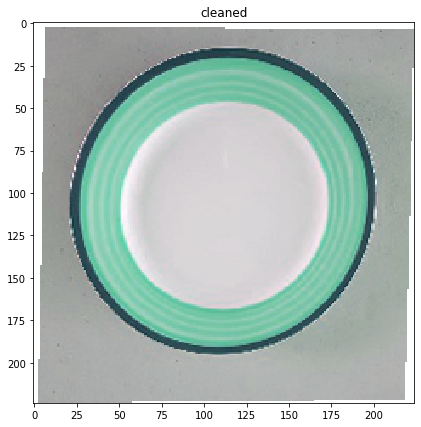

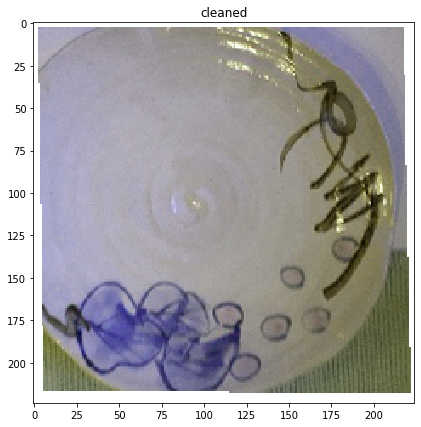

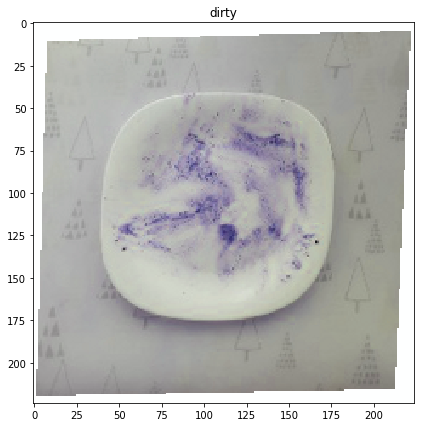

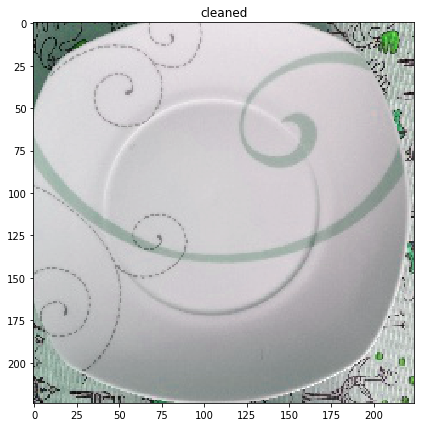

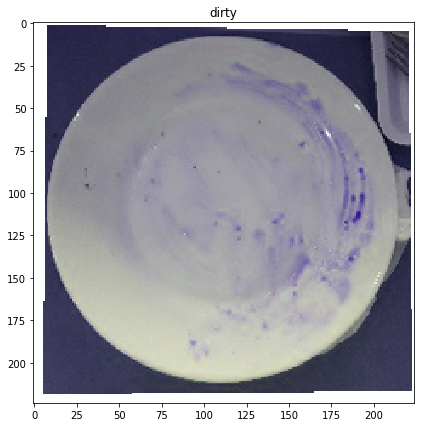

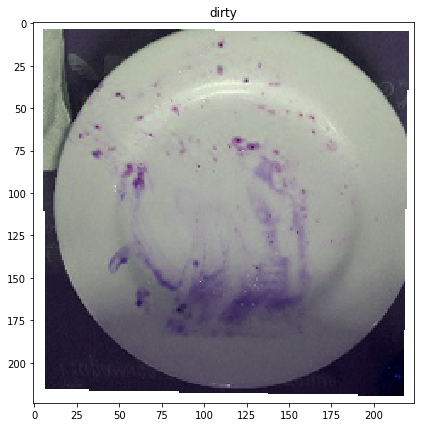

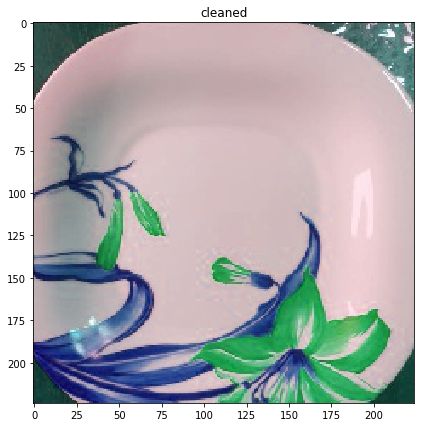

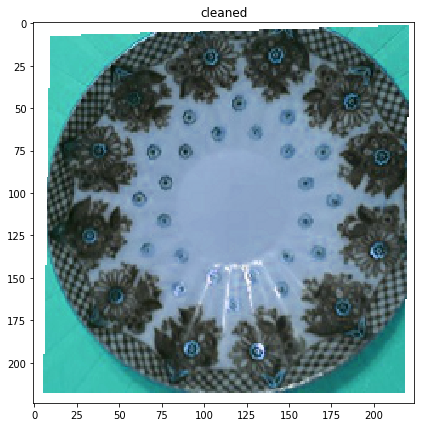

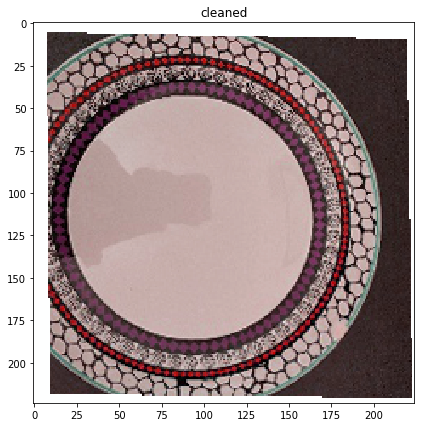

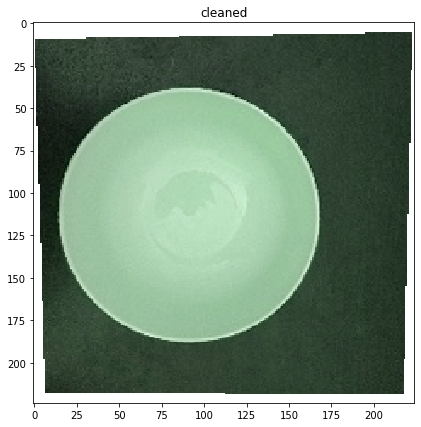

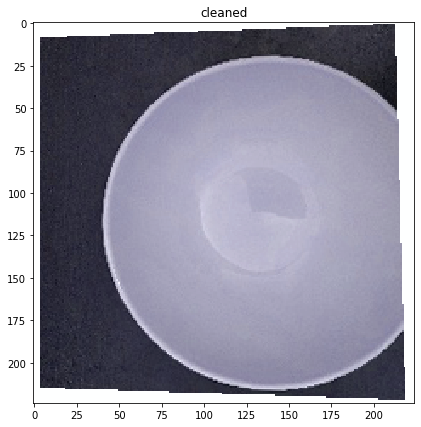

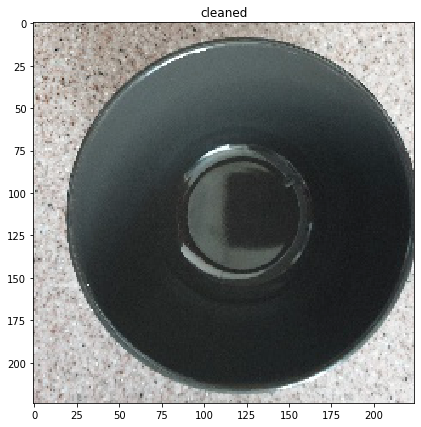

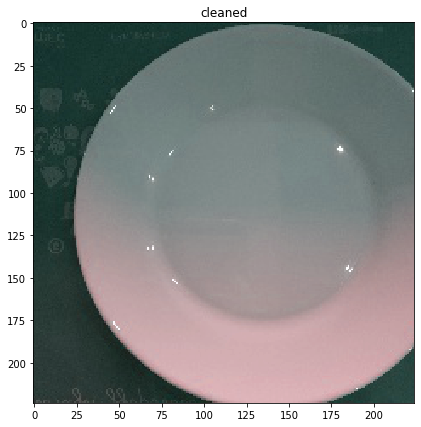

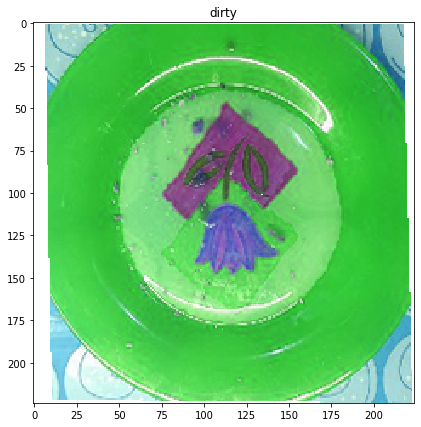

In [96]:
X_batch, y_batch = next(iter(trn_dataloader))
for x_item, y_item in zip(X_batch, y_batch):
    image_show(x_item, title=class_names[y_item])

In [97]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    
    loss_hist = {'train': [], 'val': []}
    accuracy_hist = {'train': [], 'val': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}: ', flush=True)
        
        # each epoch has a trainig and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = trn_dataloader
                model.train()  # set model to trainig mode
            else:
                dataloader = val_dataloader
                model.eval()  # set model to evaluate mode
            
            running_loss = 0
            runnig_acc = 0
            
            # iterate over data
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)
                    
                    # backward + optimize only if in trainig phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                        scheduler.step()
                
                # statistics
                running_loss += loss_value.item()
                runnig_acc += (preds_class == labels.data).float().mean()
            
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = runnig_acc / len(dataloader)
            
            loss_hist[phase].append(epoch_loss)
            accuracy_hist[phase].append(epoch_acc)
            
            print(f'{phase} Loss: {epoch_loss:.4f} || Acc: {epoch_acc:.4f}\n')
    
    return model, loss_hist, accuracy_hist

In [116]:
model = models.resnet101(pretrained=True)

# disable grads for all conv layers
for param in model.parameters():
    param.requires_grad = False
    
model.fc = torch.nn.Sequential(torch.nn.Linear(model.fc.in_features, 256),
                               torch.nn.Linear(256, 128),
                               torch.nn.Sigmoid(),
                               torch.nn.Linear(128, 2)
                              )

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)

# decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [117]:
model, loss_hist, accuracy_hist = train_model(model, loss, optimizer, scheduler, num_epochs=30)

Epoch 0/29: 



train Loss: 0.7389 || Acc: 0.5000




val Loss: 0.6798 || Acc: 0.5000

Epoch 1/29: 



train Loss: 0.6400 || Acc: 0.8750




val Loss: 0.7300 || Acc: 0.5000

Epoch 2/29: 



train Loss: 0.6731 || Acc: 0.5000




val Loss: 0.7056 || Acc: 0.5000

Epoch 3/29: 



train Loss: 0.5812 || Acc: 0.7500




val Loss: 0.6800 || Acc: 0.6250

Epoch 4/29: 



train Loss: 0.5670 || Acc: 0.9792




val Loss: 0.6797 || Acc: 0.6250

Epoch 5/29: 



train Loss: 0.5357 || Acc: 0.9792




val Loss: 0.6804 || Acc: 0.6250

Epoch 6/29: 



train Loss: 0.5211 || Acc: 1.0000




val Loss: 0.6840 || Acc: 0.5000

Epoch 7/29: 



train Loss: 0.5785 || Acc: 0.8958




val Loss: 0.6878 || Acc: 0.5000

Epoch 8/29: 



train Loss: 0.5397 || Acc: 0.9375




val Loss: 0.6860 || Acc: 0.5000

Epoch 9/29: 



train Loss: 0.5287 || Acc: 0.9167




val Loss: 0.6908 || Acc: 0.5000

Epoch 10/29: 



train Loss: 0.5573 || Acc: 0.8542




val Loss: 0.6951 || Acc: 0.5000

Epoch 11/29: 



train Loss: 0.5406 || Acc: 0.9375




val Loss: 0.7122 || Acc: 0.3750

Epoch 12/29: 



train Loss: 0.5376 || Acc: 0.9167




val Loss: 0.7265 || Acc: 0.3750

Epoch 13/29: 



train Loss: 0.5262 || Acc: 0.9792




val Loss: 0.7293 || Acc: 0.3750

Epoch 14/29: 



train Loss: 0.4998 || Acc: 0.9375




val Loss: 0.7301 || Acc: 0.3750

Epoch 15/29: 



train Loss: 0.5444 || Acc: 0.8542




val Loss: 0.7252 || Acc: 0.3750

Epoch 16/29: 



train Loss: 0.5260 || Acc: 0.9167




val Loss: 0.7381 || Acc: 0.3750

Epoch 17/29: 



train Loss: 0.5520 || Acc: 0.8750




val Loss: 0.7400 || Acc: 0.3750

Epoch 18/29: 



train Loss: 0.5484 || Acc: 0.8542




val Loss: 0.7373 || Acc: 0.3750

Epoch 19/29: 



train Loss: 0.5550 || Acc: 0.8958




val Loss: 0.7341 || Acc: 0.3750

Epoch 20/29: 



train Loss: 0.5172 || Acc: 0.9583




val Loss: 0.7106 || Acc: 0.3750

Epoch 21/29: 



train Loss: 0.5380 || Acc: 0.9375




val Loss: 0.6981 || Acc: 0.5000

Epoch 22/29: 



train Loss: 0.5389 || Acc: 0.8542




val Loss: 0.7033 || Acc: 0.5000

Epoch 23/29: 



train Loss: 0.5270 || Acc: 0.9375




val Loss: 0.7161 || Acc: 0.3750

Epoch 24/29: 



train Loss: 0.5617 || Acc: 0.7708




val Loss: 0.7328 || Acc: 0.3750

Epoch 25/29: 



train Loss: 0.5169 || Acc: 0.9167




val Loss: 0.7011 || Acc: 0.5000

Epoch 26/29: 



train Loss: 0.5404 || Acc: 0.9167




val Loss: 0.7011 || Acc: 0.5000

Epoch 27/29: 



train Loss: 0.5352 || Acc: 0.8542




val Loss: 0.6984 || Acc: 0.5000

Epoch 28/29: 



train Loss: 0.5493 || Acc: 0.9167




val Loss: 0.7155 || Acc: 0.3750

Epoch 29/29: 



train Loss: 0.5365 || Acc: 0.9167




val Loss: 0.7181 || Acc: 0.3750



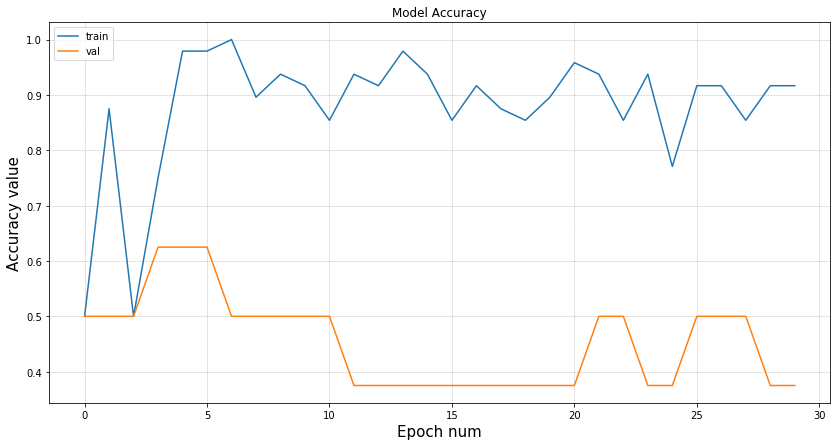

In [118]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in accuracy_hist.keys():
    plt.plot(accuracy_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

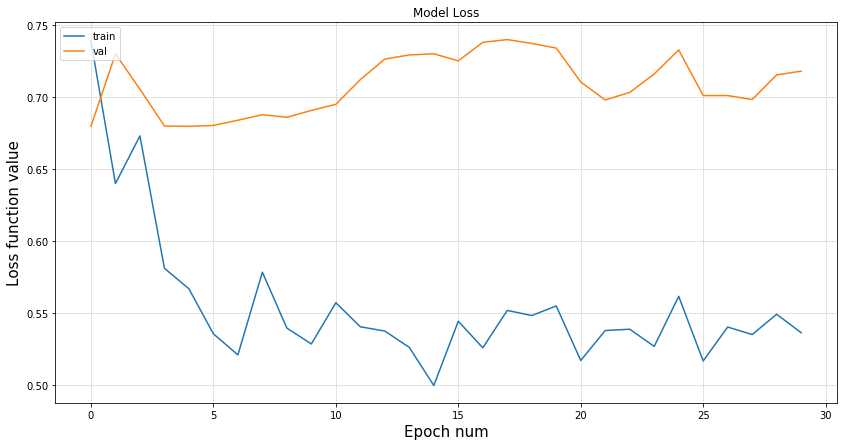

In [119]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')

In [17]:
tst_dir = 'test'

In [70]:
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(tst_dir, 'unknown'))

'test\\unknown'

In [102]:
class ImageFolderWithPaths(ImageFolder):
    
    def __getitem__(self, index):
        
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = original_tuple + (path, )
        
        return tuple_with_path

In [103]:
tst_dataset = ImageFolderWithPaths(tst_dir, val_transforms)
tst_dataloader = DataLoader(tst_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [104]:
len(tst_dataset), len(tst_dataloader)

(744, 31)

In [105]:
model.eval()
tst_preds = []
tst_img_paths = []

for inputs, labels, paths in tst_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    tst_preds.append(softmax(preds, dim=1)[:, 1].data.cpu().numpy())
    tst_img_paths.extend(paths)

tst_preds = np.concatenate(tst_preds)

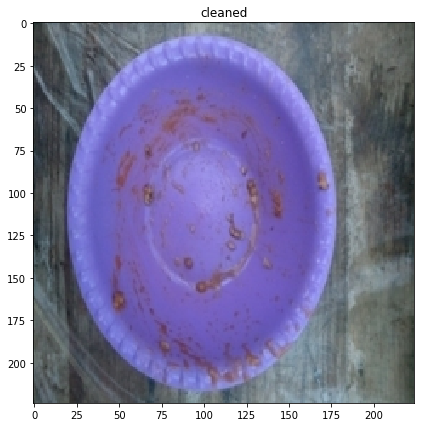

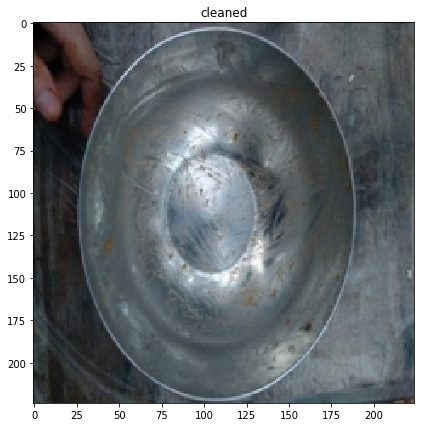

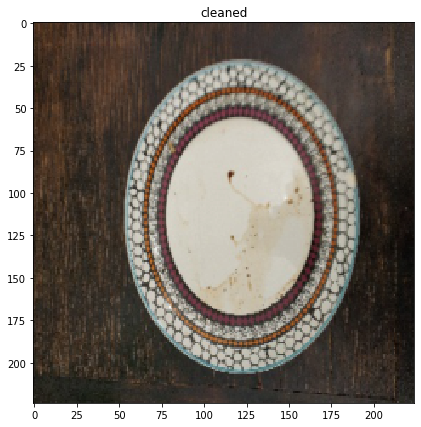

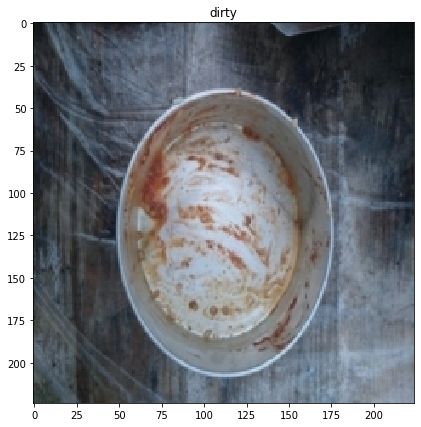

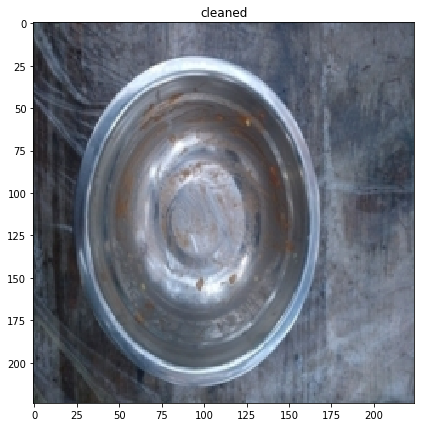

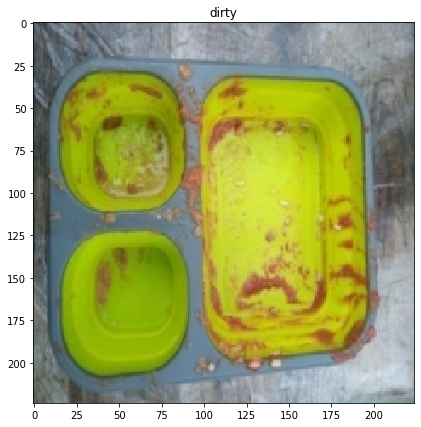

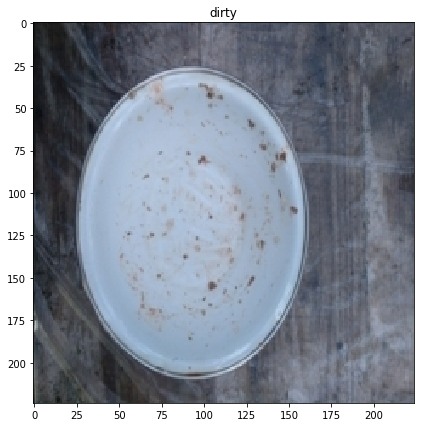

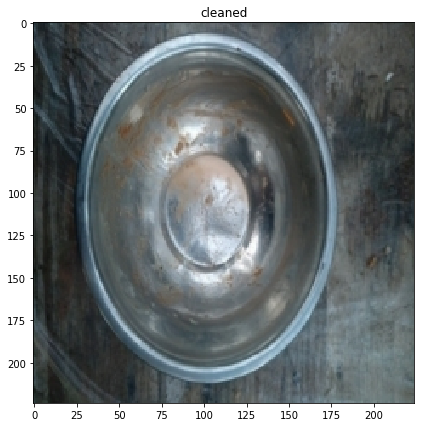

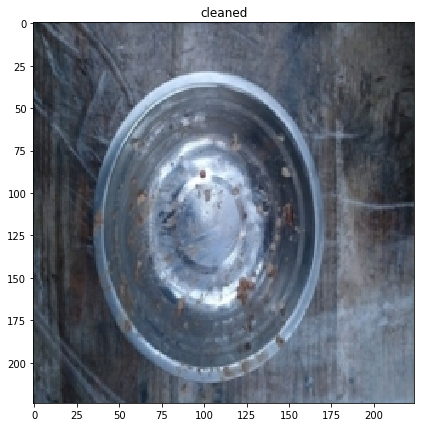

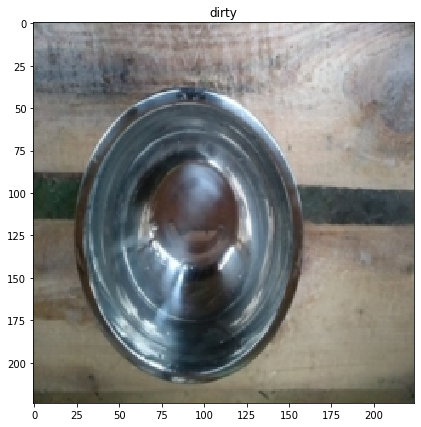

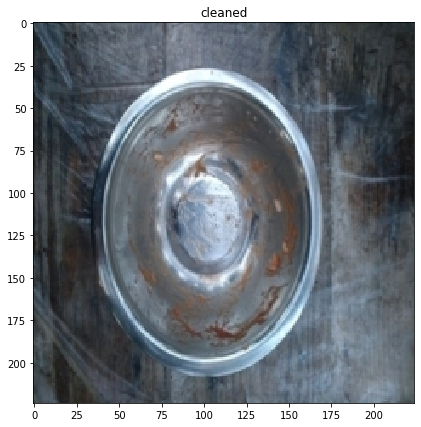

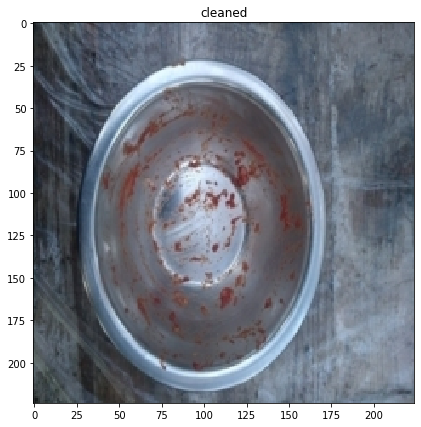

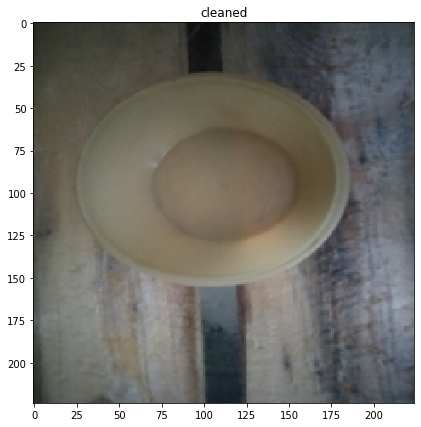

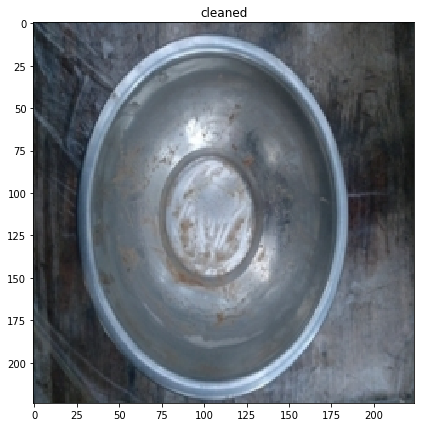

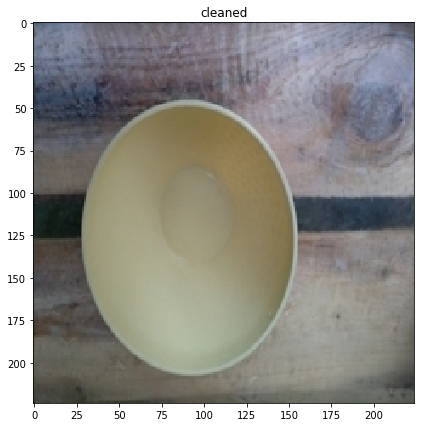

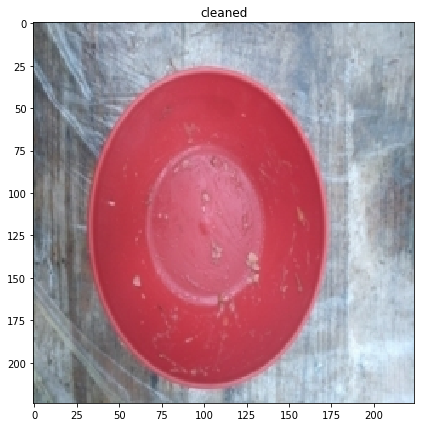

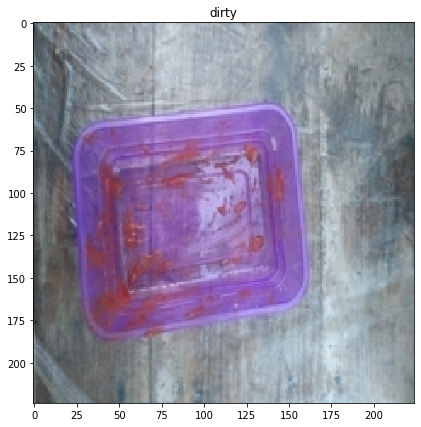

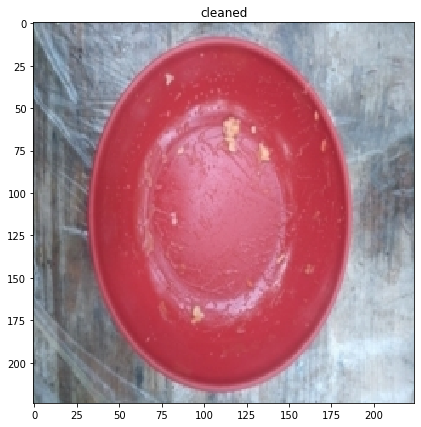

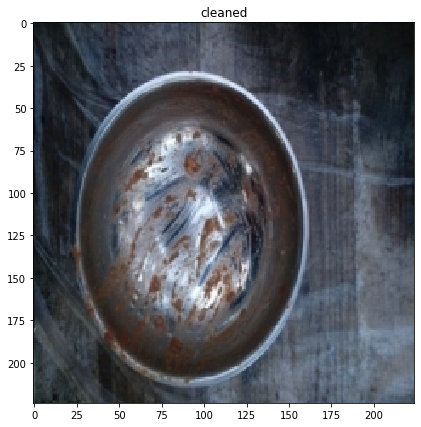

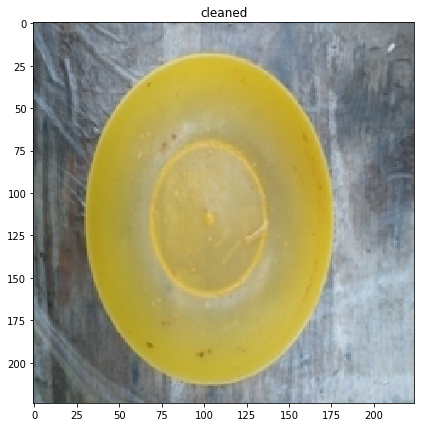

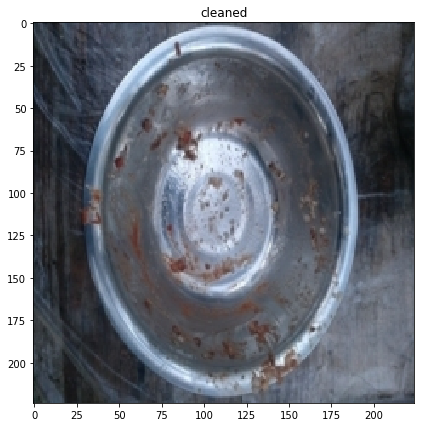

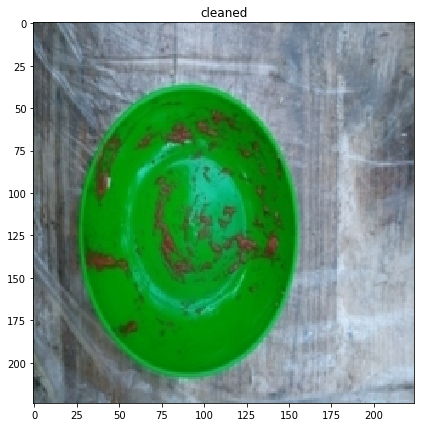

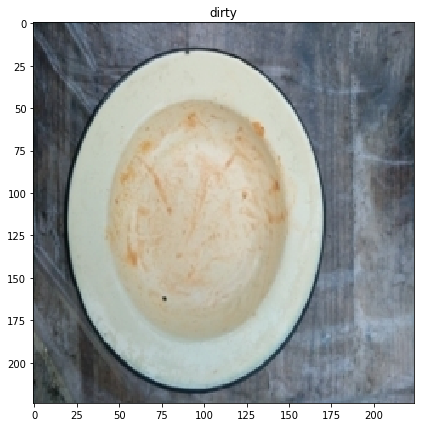

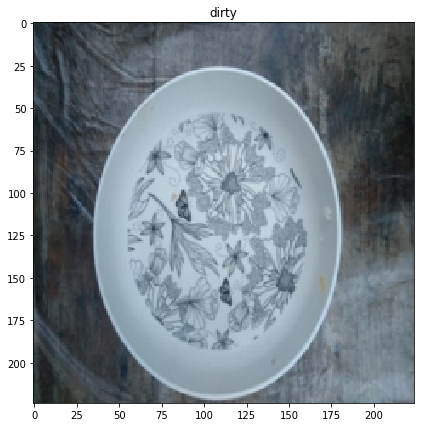

In [111]:
inputs, labels, paths = next(iter(tst_dataloader))

for img, pred in zip(inputs, tst_preds):
    image_show(img, title='dirty' if pred > 0.5 else 'cleaned')

In [69]:
sub_df = pd.DataFrame.from_dict({'id': tst_img_paths, 'label': tst_preds})
sub_df['label'] = sub_df['label'].map(lambda x: 'dirty' if x > 0.5 else 'cleaned')
sub_df['id'] = sub_df['id'].str.replace(r'test\\unknown\\', '').str.replace('.jpg', '')
sub_df.set_index('id', inplace=True)
sub_df.head(10)

label
id           
0000    dirty
0001  cleaned
0002    dirty
0003  cleaned
0004  cleaned
0005    dirty
0006    dirty
0007  cleaned
0008  cleaned
0009  cleaned

In [70]:
cur_timestamp = datetime.strftime(datetime.now(), '%Y%m%d_%H%M%S')
sub_df.to_csv(f'submissions/sub_{cur_timestamp}.csv')